# Titanic

In [49]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score, classification_report
from optuna.integration import OptunaSearchCV 
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from catboost import CatBoostClassifier

### Загрузка и ознакомление

In [50]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [51]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
train.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [54]:
train['Cabin'] = train['Cabin'].fillna('Unknown')
train['Age'] = train.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
train['Embarked'] = train['Embarked'].fillna('Unknown')


In [55]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [56]:
train.duplicated().sum()

np.int64(0)

In [57]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [59]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [60]:
test['Cabin'] = test['Cabin'].fillna('Unknown')
test['Age'] = test.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.median()))
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [61]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [62]:
test.duplicated().sum()

np.int64(0)

### EDA

Survived
0    549
1    342
Name: count, dtype: int64

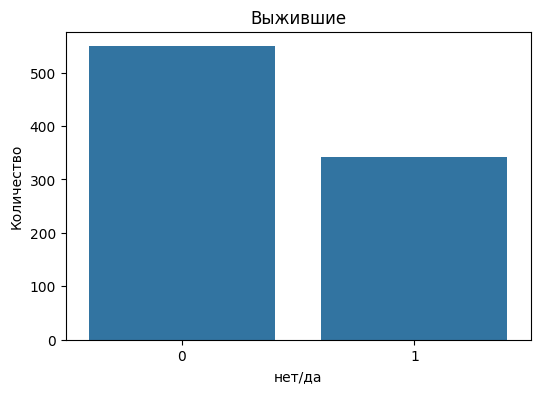

In [63]:
display(train['Survived'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Survived')
plt.title('Выжившие')
plt.xlabel('нет/да')
plt.ylabel('Количество')
plt.show()


Pclass
3    491
1    216
2    184
Name: count, dtype: int64

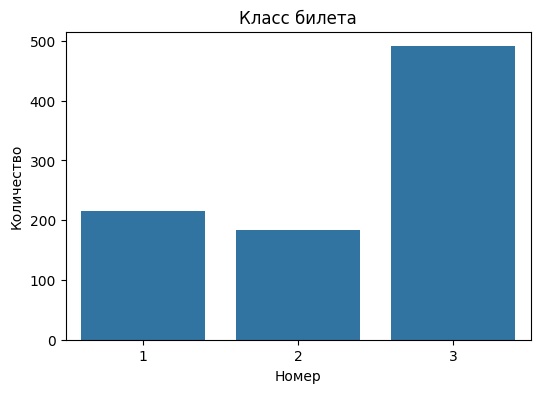

In [64]:
display(train['Pclass'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Pclass')
plt.title('Класс билета')
plt.xlabel('Номер')
plt.ylabel('Количество')
plt.show()

Sex
male      577
female    314
Name: count, dtype: int64

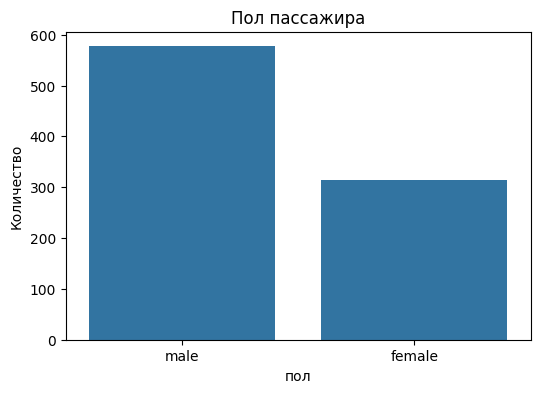

In [65]:
display(train['Sex'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Sex')
plt.title('Пол пассажира')
plt.xlabel('пол')
plt.ylabel('Количество')
plt.show()

(25.289, 30.263]    285
(20.315, 25.289]    122
(15.341, 20.315]     96
(30.263, 35.236]     88
(35.236, 40.21]      67
(40.21, 45.184]      47
(0.339, 5.394]       44
(45.184, 50.158]     39
(50.158, 55.131]     24
(5.394, 10.368]      20
(10.368, 15.341]     19
(55.131, 60.105]     18
(60.105, 65.079]     14
(70.052, 75.026]      4
(65.079, 70.052]      3
(75.026, 80.0]        1
Name: count, dtype: int64

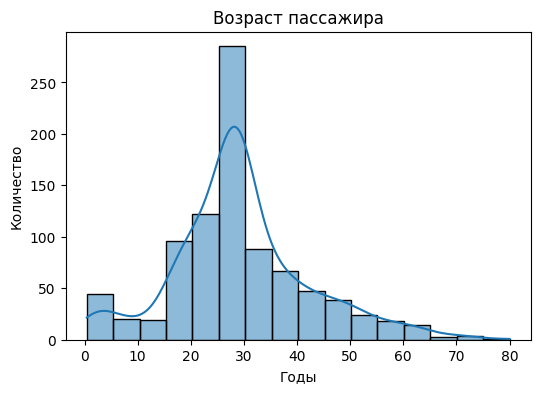

In [66]:
display(train['Age'].value_counts(bins=16))

plt.figure(figsize=(6,4))
sns.histplot(train, x='Age', bins=16, kde=True)
plt.title('Возраст пассажира')
plt.xlabel('Годы')
plt.ylabel('Количество')
plt.show()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

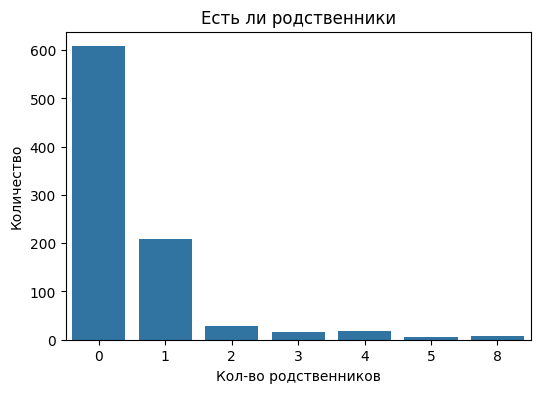

In [67]:
display(train['SibSp'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='SibSp')
plt.title('Есть ли родственники')
plt.xlabel('Кол-во родственников')
plt.ylabel('Количество')
plt.show()

Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

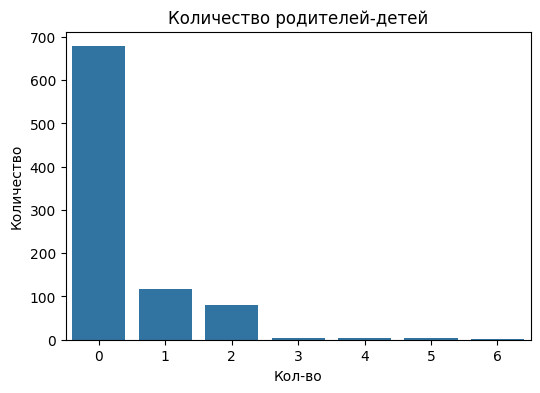

In [68]:
display(train['Parch'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Parch')
plt.title('Количество родителей-детей')
plt.xlabel('Кол-во')
plt.ylabel('Количество')
plt.show()

Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

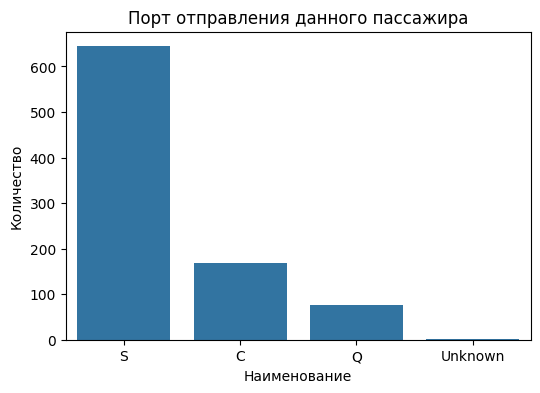

In [69]:
display(train['Embarked'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(train, x='Embarked')
plt.title('Порт отправления данного пассажира')
plt.xlabel('Наименование')
plt.ylabel('Количество')
plt.show()

### Корреляция

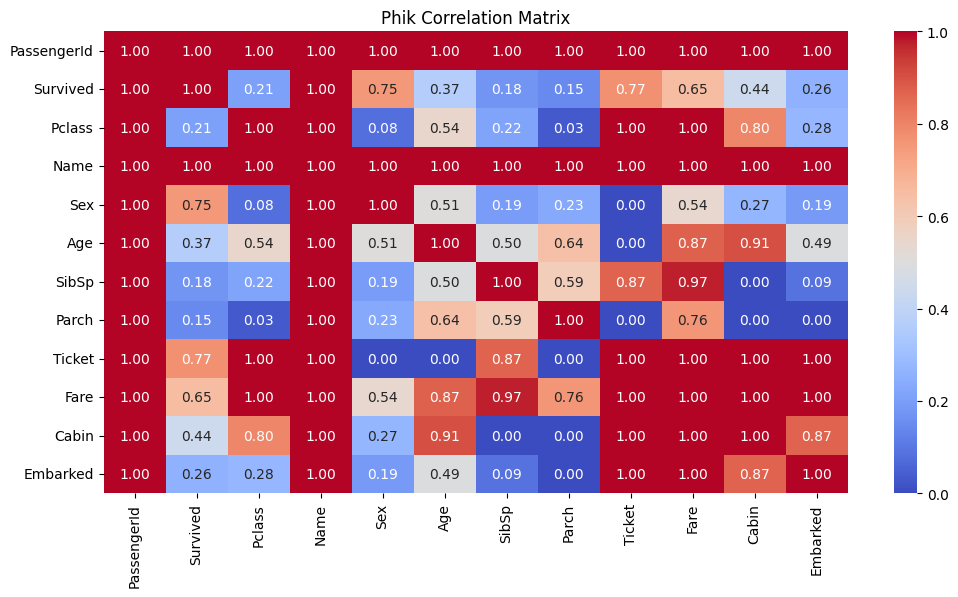

In [70]:
phik_matrix = train.phik_matrix(interval_cols='Age')

plt.figure(figsize=(12,6))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()      

In [71]:
train = train.drop(columns=['PassengerId', 'Ticket'])
test = test.drop(columns=['Ticket'])

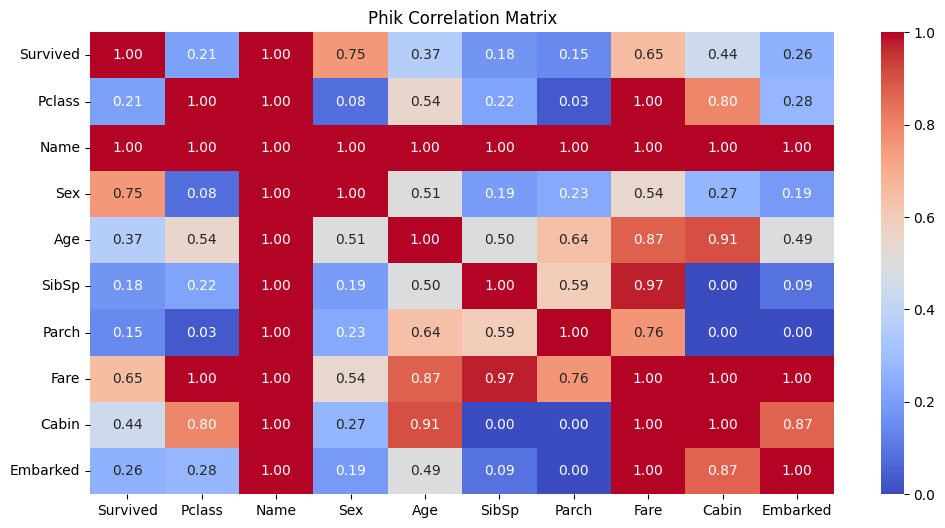

In [72]:
phik_matrix = train.phik_matrix(interval_cols='Age')
plt.figure(figsize=(12,6))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Phik Correlation Matrix")
plt.show()      

### Подготовка данных

In [73]:
# Общий размер семьи (включая самого пассажира)
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Признак "одинокий" (без семьи)
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

# Категории размера семьи
def get_family_type(size):
    if size == 1: return 'Alone'
    elif 2 <= size <= 4: return 'Small'
    else: return 'Large'
    
train['FamilyType'] = train['FamilySize'].apply(get_family_type)
test['FamilyType'] = test['FamilySize'].apply(get_family_type)

# Извлечение титула (Mr, Mrs, Miss и т.д.)
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)



# Группировка редких титулов
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Биннинг возраста
bins = [0, 12, 18, 30, 50, 100]
labels = ['Child', 'Teen', 'Young', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['AgeGroup'] = pd.cut(test['Age'], bins=bins, labels=labels)


# Первая буква номера каюты (если есть)
train['Deck'] = train['Cabin'].str[0].fillna('Unknown')
test['Deck'] = test['Cabin'].str[0].fillna('Unknown')

# Наличие информации о каюте
train['HasCabin'] = (~train['Cabin'].isna()).astype(int)
test['HasCabin'] = (~test['Cabin'].isna()).astype(int)

# Цена билета на человека
train['FarePerPerson'] = train['Fare'] / (train['FamilySize'])
test['FarePerPerson'] = test['Fare'] / (test['FamilySize'])

# Категории стоимости билета
def get_fare_type(fare):
    if fare <= 10: return 'Cheap'
    elif 10 < fare <= 50: return 'Medium'
    else: return 'Expensive'
    
train['FareType'] = train['Fare'].apply(get_fare_type)
test['FareType'] = test['Fare'].apply(get_fare_type)

# Пол + класс
train['Sex_Pclass'] = train['Sex'] + "_" + train['Pclass'].astype(str)
test['Sex_Pclass'] = test['Sex'] + "_" + test['Pclass'].astype(str)

# Возраст + класс
train['Age_Pclass'] = train['AgeGroup'].astype(str) + "_" + train['Pclass'].astype(str)
test['Age_Pclass'] = test['AgeGroup'].astype(str) + "_" + test['Pclass'].astype(str)

for dataset in [train, test]:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    dataset['Embarked'] = dataset['Embarked'].fillna('Unknown')

train = train.drop(columns=['Name'])    
test = test.drop(columns=['Name'])

#### Разбивка на трейн/тест

In [74]:
# 1. Подготовка данных
X = train.drop(columns=['Survived', 'Cabin'])
y = train['Survived']

# Заполнение пропусков и преобразование типов
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Embarked'] = X['Embarked'].fillna('Unknown')
for col in ['Sex', 'Embarked', 'Pclass']:
    X[col] = X[col].astype('str')  # Явное преобразование в строки

# Разделение с учетом дисбаланса
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)


print('Размерность выборки X_train: ', X_train.shape)
print('Размерность выборки X_val: ', X_val.shape)
print('Размерность выборки y_train: ', y_train.shape)
print('Размерность выборки y_val: ', y_val.shape)
display(X_train.head())
X_val.head()


Размерность выборки X_train:  (712, 18)
Размерность выборки X_val:  (179, 18)
Размерность выборки y_train:  (712,)
Размерность выборки y_val:  (179,)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FamilyType,Title,AgeGroup,Deck,HasCabin,FarePerPerson,FareType,Sex_Pclass,Age_Pclass
692,3,male,29.0,0,0,56.4958,S,1,1,Alone,Mr,Young,U,1,56.4958,Expensive,male_3,Young_3
481,2,male,29.0,0,0,0.0000,S,1,1,Alone,Mr,Young,U,1,0.0000,Cheap,male_2,Young_2
527,1,male,29.0,0,0,221.7792,S,1,1,Alone,Mr,Young,C,1,221.7792,Expensive,male_1,Young_1
855,3,female,18.0,0,1,9.3500,S,2,0,Small,Mrs,Teen,U,1,4.6750,Cheap,female_3,Teen_3
801,2,female,31.0,1,1,26.2500,S,3,0,Small,Mrs,Adult,U,1,8.7500,Medium,female_2,Adult_2


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FamilyType,Title,AgeGroup,Deck,HasCabin,FarePerPerson,FareType,Sex_Pclass,Age_Pclass
565,3,male,24.0,2,0,24.1500,S,3,0,Small,Mr,Young,U,1,8.050000,Medium,male_3,Young_3
160,3,male,44.0,0,1,16.1000,S,2,0,Small,Mr,Adult,U,1,8.050000,Medium,male_3,Adult_3
553,3,male,22.0,0,0,7.2250,C,1,1,Alone,Mr,Young,U,1,7.225000,Cheap,male_3,Young_3
860,3,male,41.0,2,0,14.1083,S,3,0,Small,Mr,Adult,U,1,4.702767,Medium,male_3,Adult_3
241,3,female,27.0,1,0,15.5000,Q,2,0,Small,Miss,Young,U,1,7.750000,Medium,female_3,Young_3


### Обучение модели

In [75]:
#  Настройка CatBoost с обработкой категориальных признаков
cat_features = ['Sex', 'Embarked', 'FamilyType', 'Title', 'AgeGroup', 'Deck', 'FareType', 'Sex_Pclass', 'Age_Pclass']

In [76]:
params = {
    'learning_rate': 0.001,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'verbose': 100,
    'task_type': 'CPU',
    #'devices': '0:1',
    'eval_metric': 'Accuracy',
    'cat_features': cat_features
    
}

In [77]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)


0:	learn: 0.8160112	test: 0.7932961	best: 0.7932961 (0)	total: 7.06ms	remaining: 7.05s
100:	learn: 0.8342697	test: 0.8212291	best: 0.8324022 (6)	total: 647ms	remaining: 5.76s
200:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (6)	total: 1.31s	remaining: 5.21s
300:	learn: 0.8356742	test: 0.8212291	best: 0.8324022 (6)	total: 1.98s	remaining: 4.59s
400:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (6)	total: 2.61s	remaining: 3.9s
500:	learn: 0.8370787	test: 0.8212291	best: 0.8324022 (6)	total: 3.27s	remaining: 3.26s
600:	learn: 0.8384831	test: 0.8212291	best: 0.8324022 (6)	total: 3.94s	remaining: 2.62s
700:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (6)	total: 4.58s	remaining: 1.95s
800:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (6)	total: 5.23s	remaining: 1.3s
900:	learn: 0.8398876	test: 0.8212291	best: 0.8324022 (6)	total: 5.9s	remaining: 648ms
999:	learn: 0.8412921	test: 0.8212291	best: 0.8324022 (6)	total: 6.58s	remaining: 0us

bestTest = 0.8324022346
bestIteration

#### Предсказание на тестовых данных

In [79]:
# Обработка тестовых данных в соответствии с тренировочными
test['Age'] = test['Age'].fillna(test['Age'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Embarked'] = test['Embarked'].fillna('Unknown')
for col in ['Sex', 'Embarked', 'Pclass']:
    test[col] = test[col].astype(str)

y_pred = cat_model.predict(test[cat_model.feature_names_])

# 3. Создание файла для отправки
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred
})
submission.to_csv('data/submission.csv', index=False)